# i. Business Understanding

## i.i Insurance All Company

* Insurance All is a company that provides  insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: Health insurance .


# 0.0 Imports and Helper Functions

## 0.1 Imports

In [144]:
import os
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
#import psycopg2          as pg
import scikitplot        as skplt
import category_encoders as ce

import sklearn.metrics   as mtr
import matplotlib.pyplot as plt

from scipy       import stats



from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing    import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection  import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

## 0.2 Helper Functions

In [145]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [146]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [147]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

In [148]:
def normal_tests(data):
    bx = stats.boxcox(data)[0]
    sq = np.sqrt(data)
    cb = np.cbrt(data)
    log = np.log(data)
    
    return pd.DataFrame({
        'Shapiro': [stats.shapiro(data)[0], stats.shapiro(bx)[0], stats.shapiro(sq)[0], stats.shapiro(cb)[0], stats.shapiro(log)[0]],
        'Skew': [stats.skew(data), stats.skew(bx), stats.skew(sq), stats.skew(cb), stats.skew(log)],
        'Kurtosis': [stats.kurtosis(data), stats.kurtosis(bx), stats.kurtosis(sq), stats.kurtosis(cb), stats.kurtosis(log)]
    }, index=['default', 'boxcox', 'sqrt', 'cuberoot', 'log'])

In [149]:
def top_k_precision(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})
    
    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['ranking'] = df.index + 1
    df['precision_top_k'] = df['true'].cumsum()/df['ranking']
    
    if return_df:
        return df.loc[k, 'precision_top_k'], df
    
    else:
        return df.loc[k, 'precision_top_k']

In [150]:
def top_k_recall(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})
    
    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['ranking'] = df.index + 1
    df['recall_top_k'] = df['true'].cumsum()/df['true'].sum()

    if return_df:
        return df.loc[k, 'recall_top_k'], df
    
    else:
        return df.loc[k, 'recall_top_k']

In [151]:
def top_k_f1score(y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

In [152]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    precisions = []
    recalls = []
    f1s = []
    
    ## defining
    ohe_columns = ['previously_insured', 'vehicle_damage']
    ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)
    
    te_columns = ['policy_sales_channel']
    te = ce.TargetEncoder(cols=te_columns, return_df=False)
    
    mm = MinMaxScaler()
    
    ss = StandardScaler()
    
    cs = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
          'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']
    
    ## defining as array
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for index_train, index_test in skf.split(x_, y_):
        
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## data preparation
        x_train = ohe.fit_transform(x_train)
        x_test = ohe.transform(x_test)
        
        x_train['policy_sales_channel_te'] = te.fit_transform(x_train['policy_sales_channel'], y_train)
        x_test['policy_sales_channel_te'] = te.transform(x_test['policy_sales_channel'], y_test)
        
        x_train['age_bx'] = stats.boxcox(x_train['age'])[0]
        x_test['age_bx'] = stats.boxcox(x_test['age'])[0]
        
        x_train.loc[:, 'age_bx_ss'] = ss.fit_transform(x_train[['age_bx']])
        x_test.loc[:, 'age_bx_ss'] = ss.transform(x_test[['age_bx']])
        
        x_train.loc[:, 'age_mm'] = mm.fit_transform(x_train[['age']])
        x_test.loc[:, 'age_mm'] = mm.transform(x_test[['age']])
    
        x_train = x_train[cs]
        x_test = x_test[cs]
    
        ## training the model
        model.fit(x_train, y_train)
        y_prob = model.predict_proba(x_test)

        ## saving the metrics
        k = int(0.5 * y_test.shape[0])
        
        precision = top_k_precision(y_test, y_prob, k=k)
        recall = top_k_recall(y_test, y_prob, k=k)
        f1 = 2*(precision*recall) / (precision+recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
    '''results'''
    precision_mean, precision_std = np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4)
    recall_mean, recall_std = np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4)
    f1_mean, f1_std = np.round(np.mean(f1s), 4), np.round(np.std(f1s), 4)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_mean, precision_std),
                         "Recall_at_k": "{} +/- {}".format(recall_mean, recall_std),
                         "F1_at_k": "{} +/- {}".format(f1_mean, f1_std)},
                        index=[model_name])

In [153]:
def ml_top_k_scores(model_name, y_true, y_score, k=10):
    
    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)
    f1 = top_k_f1score(y_true, y_score, k)
    
    return pd.DataFrame({'Precision_at_k': np.round(precision, 4), 
                         'Recall_at_k': np.round(recall, 4),
                         'F1_at_k': np.round(f1, 4)},
                        index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [154]:
df1=pd.read_csv('C:/Users/Raghavendra Reddy/Downloads/train.csv')


In [155]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [156]:
df1.tail()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
381104,381105,Male,74,1,26,1,1-2 Year,No,30170,26,88,0
381105,381106,Male,30,1,37,1,< 1 Year,No,40016,152,131,0
381106,381107,Male,21,1,30,1,< 1 Year,No,35118,160,161,0
381107,381108,Female,68,1,14,0,> 2 Years,Yes,44617,124,74,0
381108,381109,Male,46,1,29,0,1-2 Year,No,41777,26,237,0


## 1.2 Columns

### 1.2.1 Column Descriptions

* **Id:** Unique ID for the customer.
* **Gender:** Gender of the customer.
* **Age:** Age of the customer.
* **Driving License:** 0, customer does not have DL; 1, customer already has DL.
* **Region Code:** Unique code for the region of the customer.
* **Previously Insured:** 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance.
* **Vehicle Age:** Age of the vehicle.
* **Vehicle Damage:** 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past.
* **Anual Premium:** The amount customer needs to pay as premium in the year.
* **Policy sales channel:** Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage:** Number of Days, customer has been associated with the company.
* **Response:** 1, customer is interested; 0, customer is not interested.

### 1.2.2 Column Rename

The columns doesn't need to be changed.

### 1.2.3 Columns to Drop

In [157]:
df1 = df1.drop(columns=['id', 'id', 'id'], axis=1)

## 1.3 Data Dimensions

In [158]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 11


## 1.4 Data Types and Structures

In [159]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   gender                381109 non-null  object
 1   age                   381109 non-null  int64 
 2   driving_license       381109 non-null  int64 
 3   region_code           381109 non-null  int64 
 4   previously_insured    381109 non-null  int64 
 5   vehicle_age           381109 non-null  object
 6   vehicle_damage        381109 non-null  object
 7   annual_premium        381109 non-null  int64 
 8   policy_sales_channel  381109 non-null  int64 
 9   vintage               381109 non-null  int64 
 10  response              381109 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 32.0+ MB


## 1.5 Check NA

In [160]:
df1.isna().mean()

gender                  0.0
age                     0.0
driving_license         0.0
region_code             0.0
previously_insured      0.0
vehicle_age             0.0
vehicle_damage          0.0
annual_premium          0.0
policy_sales_channel    0.0
vintage                 0.0
response                0.0
dtype: float64

## 1.6 Fill Out NA

There's no values to fill

## 1.7 Change Data Type

I'll change the values of 0 to 'no' and 1 to 'yes' to improve the data analysis.

In [161]:
df1['previously_insured'] = df1['previously_insured'].map({0: 'no', 1: 'yes'})
df1['response'] = df1['response'].map({0: 'no', 1: 'yes'})
df1['driving_license'] = df1['driving_license'].map({0: 'no', 1: 'yes'})
df1['vehicle_damage'] = df1['vehicle_damage'].map({'Yes': 'yes', 'No': 'no'})

In [162]:
df1.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,Male,44,yes,28,no,> 2 Years,yes,40454,26,217,yes
1,Male,76,yes,3,no,1-2 Year,no,33536,26,183,no
2,Male,47,yes,28,no,> 2 Years,yes,38294,26,27,yes
3,Male,21,yes,11,yes,< 1 Year,no,28619,152,203,no
4,Female,29,yes,41,yes,< 1 Year,no,27496,152,39,no


## 1.8 Descriptions Statistics

In [163]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [164]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()
describe['mode'] = num_attributes.mode().T

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis,mode
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65,0.399551,0.672539,-0.565655,24
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52,0.501345,-0.115266,-0.867857,28
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535,0.563177,1.766087,34.004569,2630
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162,0.483816,-0.900008,-0.970810,152
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289,0.542097,0.003030,-1.200688,256


* The age mean is 39 years and the maximum value is 85 years. The variation is higher than 0.40. The skew is right skewed and kurtosis isn't 0, therefore the distribution isn't normal.
* The region code is not a normal distribution because it has got negative skew and kurtosis. The min code is 0 and it may be a invalid code. The variation is higher because it's 0.50.
* It has a higher negative skew and kurtosis!
* The range is 537,535, so there's a great difference in some users to pay. 
* The maximum number of days to be with the company is 299 days and 10 days is the minimum. The skew is almost 0.0000, however the variation coeficient is greater than 0.50 and kurstosis is negative.

### 1.8.2 Categorical Attributes

In [165]:
cat_attributes.describe().T

,count,unique,top,freq
gender,381109,2,Male,206089
driving_license,381109,2,yes,380297
previously_insured,381109,2,no,206481
vehicle_age,381109,3,1-2 Year,200316
vehicle_damage,381109,2,yes,192413
response,381109,2,no,334399


* There's only two types of gender and the top is male.
* The most common 'no', in other words, the most people in this database don't have vehicle insurance.
* The top value for driving_license is 'yes'. However, there are some people which doesn't have driving license.
* The vehicle age most common is 1-2 years.
* There are more accident vehicles than those that do not have an accident history.

In [166]:
df2 = df1

## 2.4 Selected Hypothesis

1. More than 60% of customers who want health insurance are women.


## 2.5 Feature Engineering

In [167]:
## life stage
df2['life_stage'] = df2['age'].apply(getLifeStage)

## 4.1 Loading

In [168]:
df4 = df2

## 4.2 Univariate Analysis

### 4.2.1 Response Variable

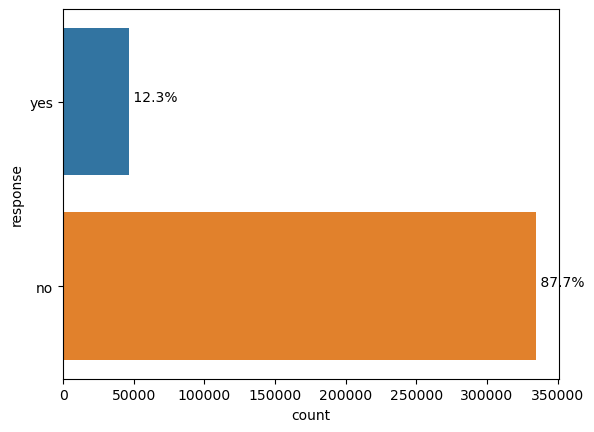

In [169]:
ax = sns.countplot(y='response', data=df4)

total = df4['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.2.2 Numerical Variables

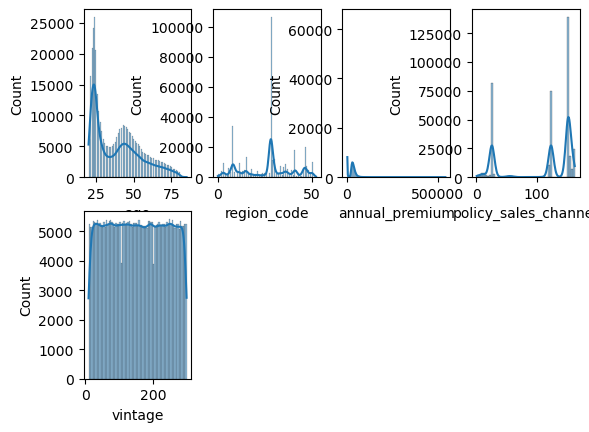

In [170]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 4, j)
    sns.histplot(aux1[column], kde=True);
    
    j += 1

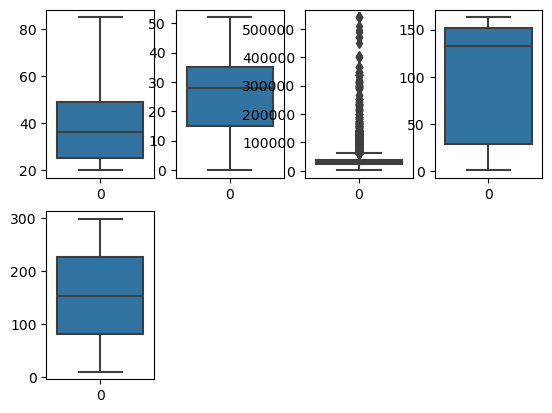

In [171]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 4, j)
    sns.boxplot(aux1[column]);
    
    j += 1

### 4.2.3 Categorical Variables

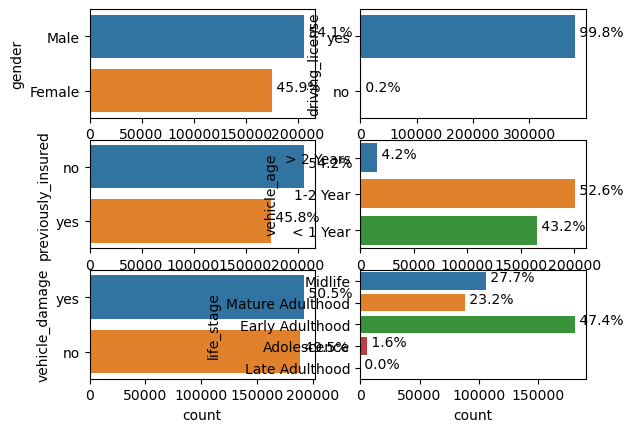

In [172]:
aux1 = df4.drop(columns=['response'], axis=1).select_dtypes(include='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=aux1)
    
    total = aux1[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 4.3 Bivariate Analysis

### H1 More than 60% of customers who want health insurance are women.

**FALSE:** Women are about 38.9% of the customers who want health insurance. 

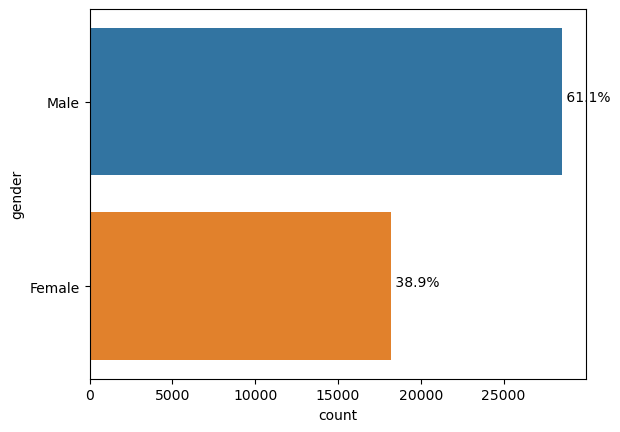

In [173]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='gender', data=aux1)

total = aux1['gender'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## 4.4 Multivariaty Analysis

### 4.4.1 Numerical

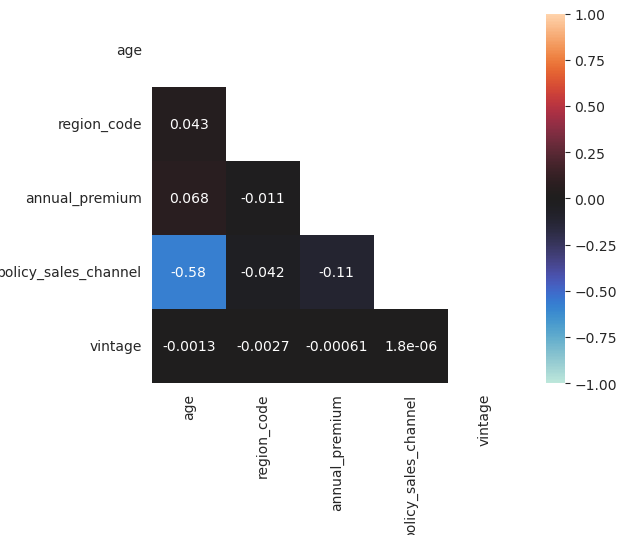

In [174]:
corr = aux1 = df4.select_dtypes(exclude='object').corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.4.2 Categorical

In [175]:
cat_attributes = df4.select_dtypes(include='object')
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

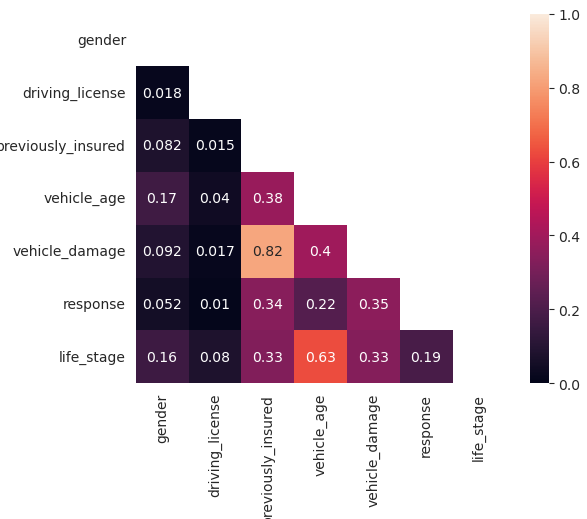

In [176]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

## 5.1 Loading

In [177]:
df5 = df4

## 5.2 Spliting into Train, Valid and Test

In [178]:
X = df5.drop(columns='response', axis=1)
y = df5['response'].map({'yes': 1, 'no': 0})

In [179]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)


## 5.3 Categorical Encoder

### 5.3.1 One Hot Encoder

In [180]:
ohe_columns = ['gender', 'previously_insured', 'driving_license', 'vehicle_damage']
ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)

In [181]:
X_params = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [182]:
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

### 5.3.2 Ordinal Encoder

In [183]:
columns_to = ['vehicle_age','life_stage' ]
oe = ce.OrdinalEncoder(cols=columns_to, 
                       mapping=[
                           {'col': 'vehicle_age', 
                            'mapping': {'< 1 Year': 1, 
                                        '1-2 Year': 2, 
                                        '> 2 Years': 3}
                           },
                           {'col': 'life_stage', 
                            'mapping': {'Adolescence': 4, 
                                        'Early Adulthood': 5, 
                                        'Midlife': 6, 
                                        'Mature Adulthood': 7, 
                                        'Late Adulthood': 8}
                           }
                       ], return_df=False)

columns_to_oe = list(map(lambda i: i + '_oe', columns_to))

X_params[columns_to_oe] = oe.fit_transform(X_params[columns_to])
X_test[columns_to_oe] = oe.transform(X_test[columns_to])

X_train[columns_to_oe] = oe.fit_transform(X_train[columns_to])
X_valid[columns_to_oe] = oe.transform(X_valid[columns_to])

### 5.3.3 Target Encoder

In [184]:
columns_to = ['region_code', 'policy_sales_channel', 'vehicle_age', 'life_stage']
te = ce.TargetEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_te', columns_to))

X_params[columns_to_te] = te.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = te.transform(X_test[columns_to])

In [185]:
X_train[columns_to_te] = te.fit_transform(X_train[columns_to], y_train)
X_valid[columns_to_te] = te.transform(X_valid[columns_to])

### 5.3.4 Count Encoder

In [186]:
columns_to = ['region_code', 'policy_sales_channel', 'vehicle_age', 'life_stage']
count = ce.CountEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_ce', columns_to))

X_params[columns_to_te] = count.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = count.transform(X_test[columns_to])

## 5.4 Natural Transformation

### 5.4.1 Age

In [187]:
normal_tests(X_params['age'])

,Shapiro,Skew,Kurtosis
default,0.909740,0.671706,-0.568536
boxcox,0.933842,0.062228,-1.348094
sqrt,0.927860,0.425563,-0.987972
cuberoot,0.930823,0.348966,-1.090802
log,0.933749,0.204254,-1.246811


In [188]:
X_params['age_bx'] = stats.boxcox(X_params['age'])[0]
X_test['age_bx'] = stats.boxcox(X_test['age'])[0]

In [189]:
X_train['age_bx'] = stats.boxcox(X_train['age'])[0]
X_valid['age_bx'] = stats.boxcox(X_valid['age'])[0]

### 5.4.2 Annual Premium

In [190]:
normal_tests(X_params['annual_premium'])

,Shapiro,Skew,Kurtosis
default,0.874452,1.721291,32.191150
boxcox,0.886389,0.075617,5.841871
sqrt,0.844158,-0.790178,0.870216
cuberoot,0.800363,-1.101751,0.481673
log,0.700827,-1.468965,0.653118


In [191]:
X_params['annual_premium_sqrt'] = np.sqrt(X_params['annual_premium'])
X_test['annual_premium_sqrt'] = np.sqrt(X_test['annual_premium'])

In [192]:
X_train['annual_premium_sqrt'] = np.sqrt(X_train['annual_premium'])
X_valid['annual_premium_sqrt'] = np.sqrt(X_valid['annual_premium'])

### 5.4.3 Vintage

In [193]:
normal_tests(df5['vintage'])

,Shapiro,Skew,Kurtosis
default,0.955203,0.003030,-1.200688
boxcox,0.956828,-0.227827,-1.080024
sqrt,0.949375,-0.456101,-0.829477
cuberoot,0.936949,-0.649572,-0.515261
log,0.888338,-1.119255,0.630900


In [194]:
X_params['vintage_cuberoot'] = np.power(X_params['vintage'], 1/3)
X_test['vintage_cuberoot'] = np.power(X_test['vintage'], 1/3)

In [195]:
X_train['vintage_cuberoot'] = np.power(X_train['vintage'], 1/3)
X_valid['vintage_cuberoot'] = np.power(X_valid['vintage'], 1/3)

## 5.5 Scaling

### 5.5.1 Standard Scaler

In [196]:
columns_to = columns_to = ['age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']
ss = StandardScaler()

columns_to_ss = list(map(lambda i: i + '_ss', columns_to))

X_params.loc[:, columns_to_ss] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_ss] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_ss] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_ss] = ss.transform(X_valid[columns_to])

### 5.5.2 MinMax Scaler 

In [197]:
columns_to = columns_to = ['age', 'vintage']
mm = MinMaxScaler()

columns_to_mm = list(map(lambda i: i + '_mm', columns_to))

X_params.loc[:, columns_to_mm] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_mm] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_mm] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_mm] = ss.transform(X_valid[columns_to])

### 5.5.3 Robust Scaler

In [198]:
columns_to = columns_to = ['annual_premium']
rs = RobustScaler()

columns_to_rs = list(map(lambda i: i + '_rs', columns_to))

X_params.loc[:, columns_to_rs] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_rs] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_rs] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_rs] = ss.transform(X_valid[columns_to])

## 5.6 Remove Columns

In [199]:
columns_to_drop = ['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'vehicle_age', 
                   'life_stage', 'age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']

X_params.drop(columns=columns_to_drop, axis=1, inplace=True)
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)

X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_valid.drop(columns=columns_to_drop, axis=1, inplace=True)

## 5.7 Saves

In [200]:
X_temp['response'] = y_temp.values

X_params['response'] = y_temp.values
X_test['response'] = y_test.values

X_train['response'] = y_train.values
X_valid['response'] = y_valid.values

# 6.0 Feature Selection

## 6.1 Loading

In [201]:
df6_temp = X_temp

df6_params = X_params
df6_test = X_test

df6_train = X_train
df6_valid = X_valid

In [202]:
X_temp, y_temp = df6_temp.iloc[:, :-1], df6_temp.iloc[:, -1]

X_params, y_params = df6_params.iloc[:, :-1], df6_params.iloc[:, -1]
X_test, y_test = df6_test.iloc[:, :-1], df6_test.iloc[:, -1]

X_train, y_train = df6_train.iloc[:, :-1], df6_train.iloc[:, -1]
X_valid, y_valid = df6_valid.iloc[:, :-1], df6_valid.iloc[:, -1]

In [203]:
columns_selected_ext = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
                        'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']

In [204]:
columns_selected_rf = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
                       'vehicle_damage_yes', 'region_code_te', 'region_code_ce', 'age_bx_ss',
                       'annual_premium_sqrt_ss', 'vintage_cuberoot_ss', 'age_mm', 'vintage_mm',
                       'annual_premium_rs']

## 6.4 Feature Importances + Extra Tree

In [205]:
columns_selected_fi = ['vehicle_damage_yes', 'vintage_mm', 'vintage_cuberoot_ss', 'previously_insured_no', 
                       'annual_premium_sqrt_ss', 'annual_premium_rs', 'annual_premium_rs', 'vehicle_damage_no']

## 6.5 Saves

In [206]:
cs = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
      'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']

X_temp_cs = X_temp[['previously_insured', 'vehicle_damage', 'policy_sales_channel', 'age']]

X_params_cs = X_params[cs]
X_test_cs = X_test[cs]

X_train_cs = X_train[cs]
X_valid_cs = X_valid[cs]

In [207]:
X_temp_cs['response'] = y_temp.values

X_params_cs['response'] = y_params.values
X_test_cs['response'] = y_test.values

X_train_cs['response'] = y_train.values
X_valid_cs['response'] = y_valid.values

# 7.0 Machine Learning Modeling

## 7.1 Loading

In [208]:
df7_params = X_params_cs
df7_test = X_test_cs

df7_train = X_train_cs
df7_valid = X_valid_cs

df7_temp = X_temp_cs

In [209]:
X_params, y_params = df7_params.iloc[:, :-1], df7_params.iloc[:, -1]
X_test, y_test = df7_test.iloc[:, :-1], df7_test.iloc[:, -1]

X_train, y_train = df7_train.iloc[:, :-1], df7_train.iloc[:, -1]
X_valid, y_valid = df7_valid.iloc[:, :-1], df7_valid.iloc[:, -1]

X_temp, y_temp = df7_temp.iloc[:, :-1], df7_temp.iloc[:, -1]

In [211]:
X_train
X_train.to_excel('C:/Users/Raghavendra Reddy/Downloads/stat5.xlsx')

## 7.3 Logistic Regression

In [67]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)

y_prob = lg.predict_proba(X_valid)

In [68]:
y_prob


array([[0.99228225, 0.00771775],
       [0.67048687, 0.32951313],
       [0.27454706, 0.72545294],
       ...,
       [0.53258921, 0.46741079],
       [0.99669209, 0.00330791],
       [0.3321847 , 0.6678153 ]])

In [ ]:
pred=y_prob[:,:1]
pred=pred.astype('int')
pred

### 7.3.1 Results

In [69]:
k = int(y_valid.shape[0] / 2)

lg_results = ml_top_k_scores('Logistic Regression', y_valid, y_prob, k=k)
lg_results

,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression,0.2424,0.989,0.3894


In [91]:
from sklearn.metrics import accuracy_score

score=accuracy_score(y_valid,pred)
print('Accuracy score',score)

Accuracy score 0.8774312046967759
